In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor,ceil
from scipy.optimize import curve_fit as cf
from pandas import read_csv

def leermd(filename):
    result = []
    df = read_csv(filename, sep='\t', skiprows=3, decimal=',')
    nparray = df.values
    nparray = nparray[~np.isnan(nparray).any(axis=1)]
    for cols in range(nparray.shape[1]):
        out = nparray[:,cols]
        result.append(out)
    return result

m_cent = 0.08148 # kg
m_mov = 0.08068 # kg
alfa = 16*np.pi/180
err_t = 1/200 # s
err_ang = 1*np.pi/180
err_dist = 0.001 # m
err_m = 0.00001 # kg
R = 0.0373 # m
d = 0.002 #m
err_R = 0.00005 # m
err_d = 0.00005 # m
g = 9.796852 # m/s²
dist_cent = np.array([0.21,0.23,0.25,0.27,0.29,0.31,0.33,0.35,0.37,0.39]) # m
dist_mov = np.array([0.145,0.150,0.155,0.160,0.165,0.170,0.175,0.180,0.185,0.190]) #m

In [2]:
def temp_calc(filename):
    ts,ph_out,ph_in = leermd(filename)
    dph_in = np.diff(ph_in)
    dph_out = np.diff(ph_out)
    
    idx_i_in = np.where(dph_in<-3.5)[0]
    idx_d_in = np.where(dph_in>3.5)[0]
    temp_in = (ts[idx_i_in]+ts[idx_d_in])/2
    
    idx_i_out = np.where(dph_out<-2.5)[0]
    idx_d_out = np.where(dph_out>2.5)[0]
    temp_out = (ts[idx_i_out]+ts[idx_d_out])/2
    
    temp = temp_out - temp_in
    
    return temp

temp_cent = []
err_st_t_cent = []
for i in range(len(dist_cent)):
    t_list = [temp_calc(str(ceil(dist_cent[i]*100)) + '-1.txt'), temp_calc(str(ceil(dist_cent[i]*100)) + '-2.txt'), temp_calc(str(ceil(dist_cent[i]*100)) + '-3.txt')]
    t_avg = np.mean(t_list)
    t_std = np.std(t_list)
    temp_cent.append(t_avg)
    err_st_t_cent.append(t_std/3)
temp_cent = np.array(temp_cent)
err_st_t_cent = np.array(err_st_t_cent)

temp_mov = []
err_st_t_mov = []
for i in range(len(dist_mov)):
    t_list = [temp_calc('C' + str(round(dist_mov[i]*200)/2) + '-1.txt'), temp_calc('C' + str(round(dist_mov[i]*200)/2) + '-2.txt'), temp_calc('C' + str(round(dist_mov[i]*200)/2) + '-3.txt')]
    t_avg = np.mean(t_list)
    t_std = np.std(t_list)
    temp_mov.append(t_avg)
    err_st_t_mov.append(t_std/3)
temp_mov = np.array(temp_mov)
err_st_t_mov = np.array(err_st_t_mov)

In [3]:
x_cent = temp_cent
y_cent = dist_cent
err_x_cent = err_t
err_y_cent = err_dist

err_rel_x_cent = err_x_cent/abs(x_cent)
err_rel_y_cent = err_y_cent/abs(y_cent)

t_ovr_x = 0
t_eq_x = 0
x_ovr_t = 0
for i in range(len(x_cent)):
    if err_rel_x_cent[i] < 0.1*err_rel_y_cent[i]:
        t_ovr_x += 1
    elif err_rel_y_cent[i] < 0.1*err_rel_x_cent[i]:
        x_ovr_t += 1
    else:
        t_eq_x += 1

print(t_ovr_x,t_eq_x,x_ovr_t)
# Hay que propagar el error del tiempo en el de la posición

0 10 0


In [4]:
quad = lambda x,a,b : a*x**2+b*x

z = 0
while t_ovr_x <= t_eq_x:
    t_ovr_x = 0
    t_eq_x = 0
    popt,cov = cf(quad,x_cent,y_cent,sigma=err_rel_y_cent)
    a_cent = popt[0]
    b_cent = popt[0]
    err_y_cent = np.sqrt(((a_cent*2*x_cent+b_cent)*err_x_cent)**2+err_y_cent**2)
    err_rel_y_cent = err_y_cent/abs(y_cent)
    for i in range(len(x_cent)):
        if err_rel_x_cent[i] < 0.1*err_rel_y_cent[i]:
            t_ovr_x += 1
        else:
            t_eq_x += 1
    z += 1

print(t_ovr_x)
print(z)

6
231


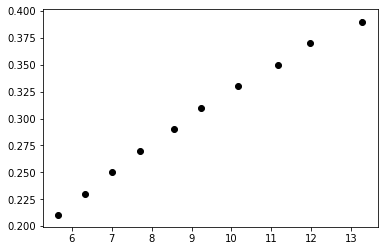

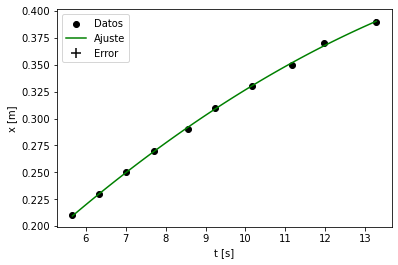

-0.0009984
4e-10


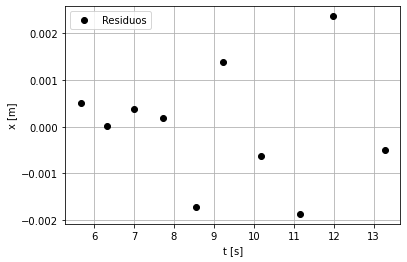

In [5]:
popt,cov = cf(quad,x_cent,y_cent,sigma=err_rel_y_cent)
a_cent = popt[0]
b_cent = popt[1]
err_a_cent = cov[0][0]
err_b_cent = cov[1][1]

x_adj_cent = np.linspace(min(x_cent),max(x_cent),100)
y_adj_cent= quad(x_adj_cent,a_cent,b_cent)

plt.figure()
plt.errorbar(x_cent,y_cent,xerr=err_x_cent,yerr=err_y_cent,fmt='k',ls='none')
plt.scatter(x_cent,y_cent,color='k')
plt.show()
plt.close()

plt.figure()
plt.scatter(x_cent,y_cent,color='k',label='Datos')
plt.errorbar(x_cent,y_cent,xerr=err_x_cent,yerr=err_y_cent,fmt='k',ls='none',label='Error')
plt.plot(x_adj_cent,y_adj_cent,'g',label='Ajuste')
plt.xlabel('t [s]')
plt.ylabel('x [m]')
plt.legend()
plt.savefig('quad_graph_cent.jpg')
plt.show()
plt.close()

print(round(a_cent,-int(floor(np.log10(abs(err_a_cent))))))
print(round(err_a_cent,-int(floor(np.log10(abs(err_a_cent))))))


res_cent = y_cent - quad(x_cent,a_cent,b_cent)

plt.figure()
plt.grid()
plt.plot(x_cent,res_cent,'ko',label='Residuos')
plt.xlabel('t [s]')
plt.ylabel('x [m]')
plt.legend()
plt.savefig('quad_res_cent.jpg')
plt.show()
plt.close()

In [6]:
I_cent = m_cent*R**2*((g*np.sin(alfa)/(2*abs(a_cent))) - 1)
print(I_cent)

I_cent_teo = m_cent*R**2/2
print(I_cent_teo)

0.1531924858104431
5.668115459999999e-05


In [7]:
err_I_cent = np.sqrt((I_cent*err_m/m_cent)**2 + (2*I_cent*err_R/R)**2 + (m_cent*R**2*g*np.cos(alfa)*err_ang/(2*a_cent))**2 + (m_cent*R**2*g*np.sin(alfa)*err_a_cent/(2*a_cent**2))**2)
print(err_I_cent)

err_I_cent_teo = np.sqrt((R**2*err_m/2)**2+(m_cent*R*err_R)**2)

print(err_I_cent_teo)

0.009340299141139511
1.5211934321657617e-07


In [8]:
print(f'I_cm = ({(round(I_cent,-int(floor(np.log10(abs(err_I_cent))))))} ± {round(err_I_cent,-int(floor(np.log10(abs(err_I_cent)))))}) kgm²')
print(f'I_cm_teo = ({(round(I_cent_teo,-int(floor(np.log10(abs(err_I_cent_teo))))))} ± {round(err_I_cent_teo,-int(floor(np.log10(abs(err_I_cent_teo)))))}) kgm²')

print(a_cent)
print(f'k_cent = ({round(a_cent,-int(floor(np.log10(abs(err_a_cent)))))} ± {round(err_a_cent,-int(floor(np.log10(abs(err_a_cent)))))}) m/s²')

err_rel_I_cent = err_I_cent/I_cent
err_rel_I_cent_teo = err_I_cent_teo/I_cent_teo

print(str(round(err_rel_I_cent*100,1)) + '%')
print(str(round(err_rel_I_cent_teo*100,1)) + '%')

res_sq_cent = res_cent**2
ss_tot_cent = np.sum((y_cent-np.mean(y_cent))**2)
r2_cent = 1 - np.sum(res_sq_cent/ss_tot_cent)

print(f'R² = {round(r2_cent,5)}')

print(round(abs(I_cent-I_cent_teo),3))
print(round(err_I_cent+err_I_cent_teo,3))

I_cm = (0.153 ± 0.009) kgm²
I_cm_teo = (5.67e-05 ± 2e-07) kgm²
-0.000998400037227729
k_cent = (-0.0009984 ± 4e-10) m/s²
6.1%
0.3%
R² = 0.99954
0.153
0.009


In [9]:
x_mov = temp_mov
y_mov = dist_mov
err_x_mov = err_t
err_y_mov = err_dist

err_rel_x_mov = err_x_mov/abs(x_mov)
err_rel_y_mov = err_y_mov/abs(y_mov)

t_ovr_x = 0
t_eq_x = 0
x_ovr_t = 0
for i in range(len(x_mov)):
    if err_rel_x_mov[i] < 0.1*err_rel_y_mov[i]:
        t_ovr_x += 1
    elif err_rel_y_mov[i] < 0.1*err_rel_x_mov[i]:
        x_ovr_t += 1
    else:
        t_eq_x += 1

print(t_ovr_x,t_eq_x,x_ovr_t)

0 10 0


In [10]:
z = 0
while t_ovr_x <= t_eq_x:
    t_ovr_x = 0
    t_eq_x = 0
    popt,cov = cf(quad,x_mov,y_mov,sigma=err_rel_y_mov)
    a_mov = popt[0]
    b_mov = popt[1]
    err_y_mov = np.sqrt(((a_mov*2*x_mov+b_mov)*err_x_mov)**2+err_y_mov**2)
    err_rel_y_mov = err_y_mov/abs(y_mov)
    for i in range(len(x_mov)):
        if err_rel_x_mov[i] < 0.1*err_rel_y_mov[i]:
            t_ovr_x += 1
        else:
            t_eq_x += 1
    z += 1

print(t_ovr_x)
print(z)

6
83


-0.00079132
4e-08


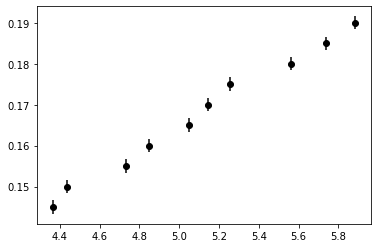

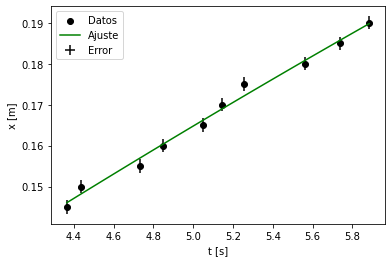

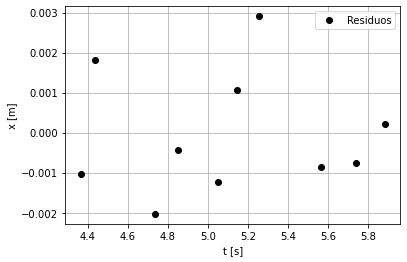

In [11]:
popt,cov = cf(quad,x_mov,y_mov,sigma=err_rel_y_mov)
a_mov = popt[0]
b_mov = popt[1]
err_a_mov = cov[0][0]
err_b_mov = cov[1][1]

print(round(a_mov,-int(floor(np.log10(abs(err_a_mov))))))
print(round(err_a_mov,-int(floor(np.log10(abs(err_a_mov))))))

x_adj_mov = np.linspace(min(x_mov),max(x_mov),100)
y_adj_mov = quad(x_adj_mov,a_mov,b_mov)

plt.errorbar(x_mov,y_mov,xerr=err_x_mov,yerr=err_y_mov,fmt='k',ls='none')
plt.scatter(x_mov,y_mov,color='k')

plt.figure()
plt.scatter(x_mov,y_mov,color='k',label='Datos')
plt.errorbar(x_mov,y_mov,xerr=err_x_mov,yerr=err_y_mov,fmt='k',ls='none',label='Error')
plt.plot(x_adj_mov,y_adj_mov,'g',label='Ajuste')
plt.xlabel('t [s]')
plt.ylabel('x [m]')
plt.legend()
plt.savefig('quad_graph_mov.jpg')
plt.show()
plt.close()

res_mov = y_mov - quad(x_mov,a_mov,b_mov)

plt.figure()
plt.grid()
plt.plot(x_mov,res_mov,'ko',label='Residuos')
plt.savefig('quad_res_mov.jpg')
plt.xlabel('t [s]')
plt.ylabel('x [m]')
plt.legend()
plt.show()
plt.close()

In [12]:
I_mov = m_mov*R**2*(g*np.sin(alfa)/(2*abs(a_mov)) * (1-d/R) - 1)
I_mov_teo = m_mov*R**2/2 + m_mov*d**2

print(I_mov)
print(I_mov_teo)

0.18114332430924912
5.644735859999999e-05


In [13]:
err_I_mov = np.sqrt( (I_mov*err_m/m_mov)**2 + ((m_mov*g*np.sin(alfa)*(2*R-d)/(2*a_mov)-2*m_mov*R)*err_R)**2 + (m_mov*R*g*np.sin(alfa)/(2*a_mov)*err_d)**2 + (m_mov*R**2*g*np.sin(alfa)/(2*a_mov)*(1-d/R)*err_ang)**2 + (m_mov*R**2*g*np.sin(alfa)*(1-d/R)/(2*a_mov**2)*err_a_mov)**2 )
print(err_I_mov)

err_I_mov_teo = np.sqrt(((R**2/2+d**2)*err_m)**2 + (m_mov*(R+d**2)*err_R)**2 + (m_mov*(R**2/2+2*d)*err_d)**2)
print(err_I_mov_teo)



0.0032131428965317147
1.5183311181838204e-07


In [14]:
print(f'I_p = ({(round(I_mov,-int(floor(np.log10(abs(err_I_mov))))))} ± {round(err_I_mov,-int(floor(np.log10(abs(err_I_mov)))))}) kgm²')
print(f'I_p_teo = ({(round(I_mov_teo,-int(floor(np.log10(abs(err_I_mov_teo))))))} ± {round(err_I_mov_teo,-int(floor(np.log10(abs(err_I_mov_teo)))))}) kgm²')

err_rel_I_mov = err_I_mov/I_mov
err_rel_I_mov_teo = err_I_mov_teo/I_mov_teo

print(str(round(err_rel_I_mov*100,1)) + '%')
print(str(round(err_rel_I_mov_teo*100,1)) + '%')

res_sq_mov = res_mov**2
ss_tot_mov = np.sum((y_mov-np.mean(y_mov))**2)
r2_mov = 1 - np.sum(res_sq_mov/ss_tot_mov)

print(f'R² = {round(r2_mov,5)}')

print(round(abs(I_mov-I_mov_teo),3))
print(round(err_I_mov+err_I_mov_teo,3))

I_p = (0.181 ± 0.003) kgm²
I_p_teo = (5.64e-05 ± 2e-07) kgm²
1.8%
0.3%
R² = 0.98974
0.181
0.003


In [17]:
I_mov_steiner = I_cent + m_cent*d**2
print(I_mov)

err_I_mov_steiner = np.sqrt(err_I_cent**2 + (d**2*err_m)**2 + (2*m_cent*d*err_d)**2)

print(f'I_p_steiner = ({(round(I_mov_steiner,-int(floor(np.log10(abs(err_I_mov_steiner))))))} ± {round(err_I_mov_steiner,-int(floor(np.log10(abs(err_I_mov_steiner)))))}) kgm²')

0.18114332430924912
I_p_steiner = (0.153 ± 0.009) kgm²
